<a href="https://colab.research.google.com/github/LorneBarnaby/mhci-coursework/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
from google.colab import auth
import gspread
from google.auth import default#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [184]:
ws = gc.open('MHCI Coursework (Responses)').sheet1

In [190]:
rows = ws.get_all_values()
print(rows)

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(rows)

[['Timestamp', 'I am over the age of 16 and I consent to taking part in this experiment. I understand that I can withdraw at any time.', 'What model of phone and browser are you using for this experiment', 'Did you manage to complete the task', 'If you did not manage to complete the task describe what happened otherwise answer "NA"', 'What was the value given of "betalower"', 'What was the value given of "betaupper"', 'What was the value given of "tt"', 'On a scale of 1-10 how difficult was the task to complete using the interface', 'Roughly how many times did you have to repeat words to get the interface to understand you', 'Did you manage to complete the task', 'If you did not manage to complete the task describe what happened otherwise answer "NA"', 'What was the value given of "betalower"', 'What was the value given of "betaupper"', 'What was the value given of "tt"', 'On a scale of 1-10 how difficult was the task to complete using the interface', 'Roughly how many times did you ha

In [186]:
from dataclasses import dataclass, fields
from pydantic import validate_call
import numpy as np

@validate_call
@dataclass
class TaskResult:
  complete: str
  detail: str
  lower: int
  upper: int
  timetaken: float
  difficulty: int
  repeats: str
  centre: int = 0
  diff: int = 0
  taskId:int = 0

  @property
  def centre(self):
    return (self.upper + self.lower)//2

  @property
  def diff(self):
    return self.upper - self.centre


class UserResults:
  def __init__(self, tasks):
    self.tasks = tasks

    self.setup()

  def setup(self):
    for field in fields(TaskResult):
      fn = field.name
      # for task in self.tasks:
      #   print(field.name, getattr(task, field.name))
      vals = np.array(list(map(lambda t: getattr(t, field.name), self.tasks)))
      setattr(self, field.name, vals)

      funcs = {
          'min': np.min,
          'max': np.max,
          'mean': np.mean,
          'arg_min': np.argmin,
          'arg_max': np.argmax,
      }

      if(field.type != str):
        for name, func in funcs.items():
          setattr(self, f'{field.name}_{name}', func(vals))


  def __repr__(self):
    return str(self.tasks)

  def sortBy(self, field):
    return np.argsort(getattr(self,field))




In [187]:


userTasks = []
for userRow in range(1, df.shape[0]):

  tasks = []
  startInd = 3
  jump = 7
  endInd = 23
  taskid = 1
  while startInd < endInd:
    t = TaskResult(*df.iloc[userRow,startInd:startInd+jump])
    t.taskId = taskid
    tasks.append(t)
    startInd += jump
    taskid +=1
  userTasks.append(UserResults(tasks))

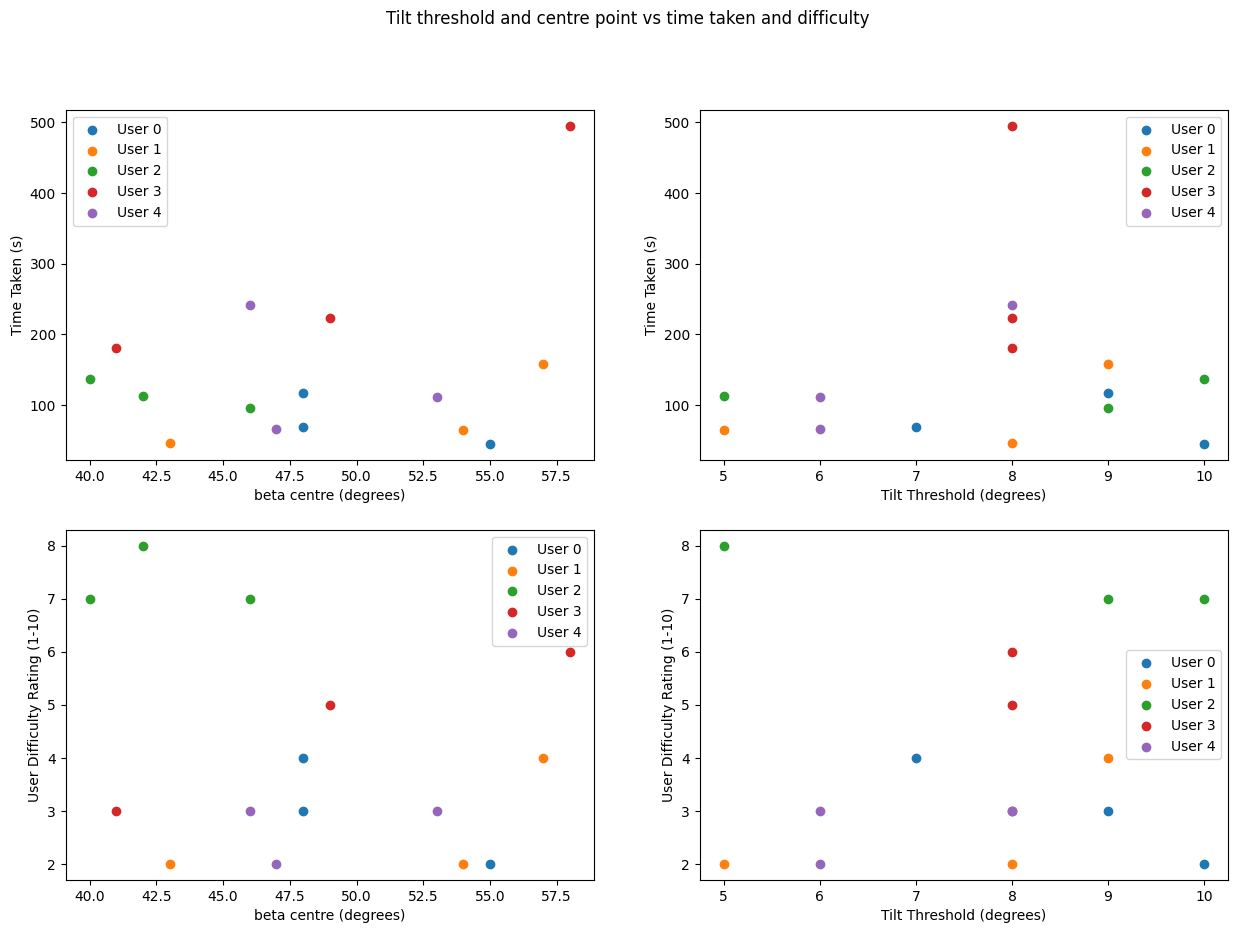

In [188]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2,2, figsize=(15,10))

yvars = ['timetaken', 'difficulty']
xvars = ['centre', 'diff']
labels = {'centre': "beta centre (degrees)", "diff":"Tilt Threshold (degrees)", 'timetaken':"Time Taken (s)", 'difficulty': 'User Difficulty Rating (1-10)'}
for raxis, yvar in zip(ax, yvars):

  for axis, xvar in zip(raxis, xvars):
    for userId, userResults in enumerate(userTasks):
      xs = getattr(userResults, xvar)
      order = np.argsort(xs)
      # ys = userResults.timetaken
      ys = getattr(userResults, yvar)


      axis.scatter(xs[order], ys[order], label=f'User {userId}')
      axis.legend()
    axis.set_xlabel(labels[xvar])
    # if(yvar == 'timetaken'):
    #   yvar += ' (s)'
    axis.set_ylabel(labels[yvar])

fig.suptitle("Tilt threshold and centre point vs time taken and difficulty")
fig.savefig("TiltCentreTTDif.png")

In [189]:
for userId, userResults in enumerate(userTasks):
  print("Best beta for user",userId,
        "by difficulty:", userResults.centre[userResults.difficulty_arg_min],
        "by time taken:", userResults.centre[userResults.timetaken_arg_min])

  print("Best diff for user",userId,
        "by difficulty:", userResults.diff[userResults.difficulty_arg_min],
        "by time taken:", userResults.diff[userResults.timetaken_arg_min])

  print(f"User {userId} & {userResults.centre[userResults.difficulty_arg_min]} & {userResults.centre[userResults.timetaken_arg_min]} & {userResults.diff[userResults.difficulty_arg_min]} & {userResults.diff[userResults.timetaken_arg_min]}")

  print("\n")

Best beta for user 0 by difficulty: 55 by time taken: 55
Best diff for user 0 by difficulty: 10 by time taken: 10
User 0 & 55 & 55 & 10 & 10


Best beta for user 1 by difficulty: 43 by time taken: 43
Best diff for user 1 by difficulty: 8 by time taken: 8
User 1 & 43 & 43 & 8 & 8


Best beta for user 2 by difficulty: 46 by time taken: 46
Best diff for user 2 by difficulty: 9 by time taken: 9
User 2 & 46 & 46 & 9 & 9


Best beta for user 3 by difficulty: 41 by time taken: 41
Best diff for user 3 by difficulty: 8 by time taken: 8
User 3 & 41 & 41 & 8 & 8


Best beta for user 4 by difficulty: 47 by time taken: 47
Best diff for user 4 by difficulty: 6 by time taken: 6
User 4 & 47 & 47 & 6 & 6


